In [1]:
#@title LICENSE
# Licensed under the Apache License, Version 2.0

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/jaxpruner/blob/main/colabs/mnist_pruning.ipynb)

## Imports / Helpers

In [2]:
from absl import logging
import flax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from flax import linen as nn
from flax.metrics import tensorboard
from flax.training import train_state
import jax
import optax
import tensorflow as tf
# Hide any GPUs form TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], "GPU")


logging.set_verbosity(logging.INFO)

In [3]:
# !pip3 install git+https://github.com/google-research/jaxpruner
import jaxpruner
import ml_collections

## Dataset

In [4]:
def get_datasets():
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [5]:
# Get datasets as dict of JAX arrays.
train_ds, test_ds = get_datasets()

INFO:absl:Load dataset info from /home/mike/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/mike/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/mike/tensorflow_datasets/mnist/3.0.1
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/mike/tensorflow_datasets/mnist/3.0.1


: 

: 

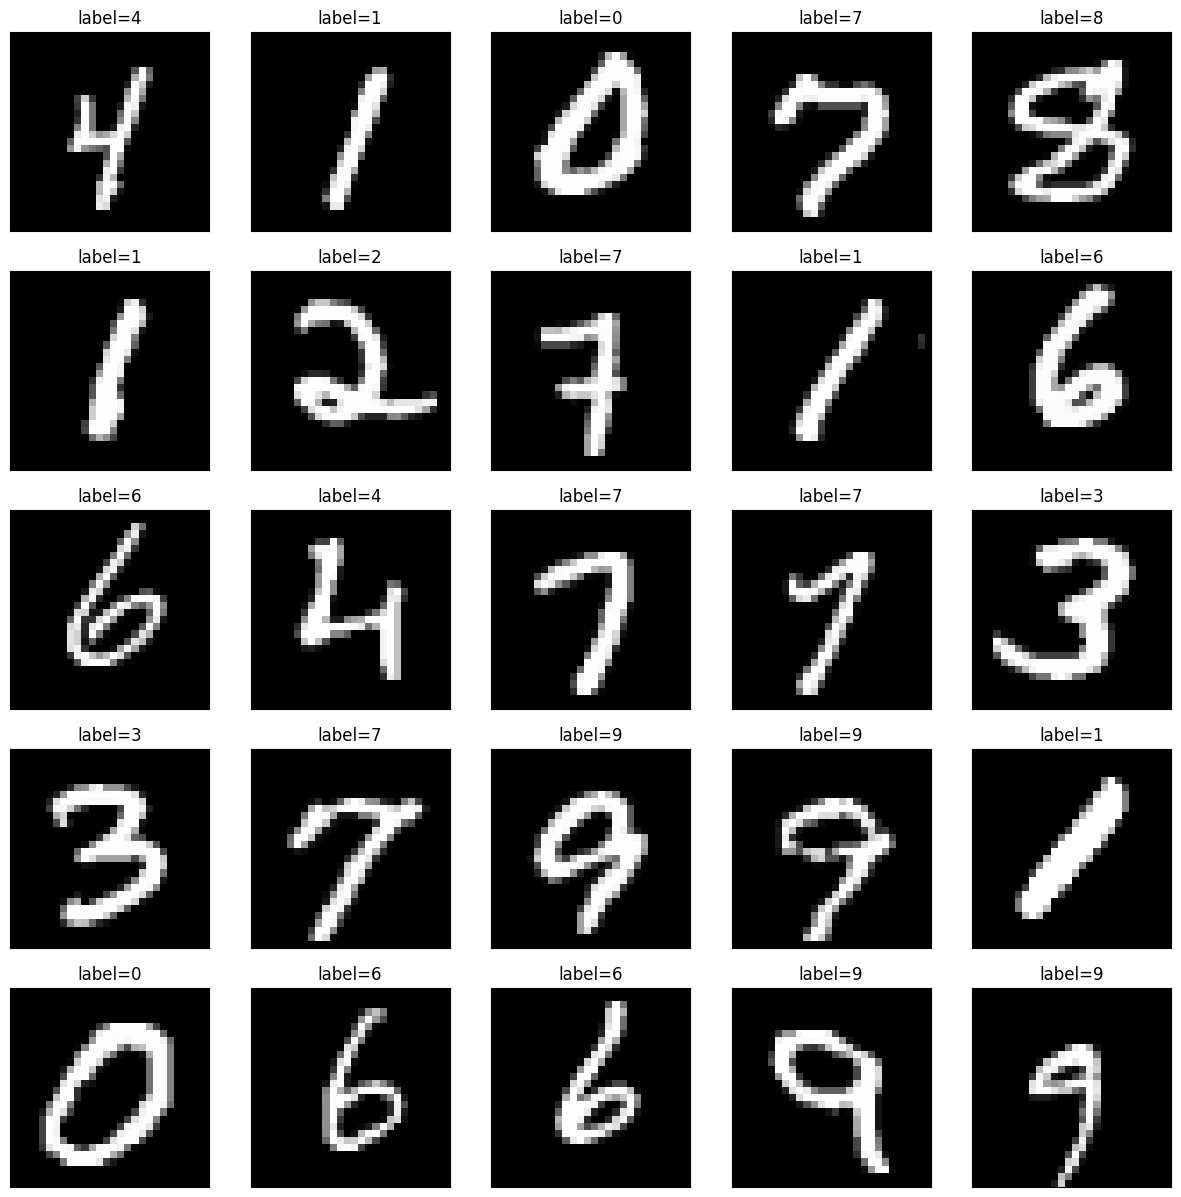

In [ ]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'label={train_ds["label"][idx]}' for idx in range(25)],
)

## Training

In [ ]:
import ml_collections

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x


@jax.jit
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, images)
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
  updates, new_opt_state = state.tx.update(
      grads, state.opt_state, state.params)
  new_params = optax.apply_updates(state.params, updates)
  return state.replace(
      step=state.step + 1,
      params=new_params,
      opt_state=new_opt_state)


def train_epoch(state, train_ds, batch_size, rng, sparsity_updater):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []
  epoch_accuracy = []
  is_ste = isinstance(sparsity_updater, (jaxpruner.SteMagnitudePruning,
                                         jaxpruner.SteRandomPruning))
  pre_op = jax.jit(sparsity_updater.pre_forward_update)
  for i, perm in enumerate(perms):
    batch_images = train_ds['image'][perm, ...]
    batch_labels = train_ds['label'][perm, ...]
    # Following is only needed for STE.
    new_params = pre_op(state.params, state.opt_state)
    forward_state = state.replace(params=new_params)

    grads, loss, accuracy = apply_model(forward_state, batch_images,
                                        batch_labels)
    state = update_model(state, grads)
    post_params = sparsity_updater.post_gradient_update(
        state.params, state.opt_state)
    state = state.replace(params=post_params)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    if i % 100 == 0:
      if is_ste:
        print(jaxpruner.summarize_sparsity(
            new_params, only_total_sparsity=True))
      else:
        print(jaxpruner.summarize_sparsity(
            state.params, only_total_sparsity=True))
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
  tx = optax.sgd(config.learning_rate, config.momentum)
  tx = sparsity_updater.wrap_optax(tx) 

  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx), sparsity_updater


import time

def train_and_evaluate(config: ml_collections.ConfigDict
                       ) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.
    workdir: Directory where the tensorboard summaries are written to.

  Returns:
    The train state (which includes the `.params`).
  """
  train_ds, test_ds = get_datasets()
  rng = jax.random.PRNGKey(0)

  rng, init_rng = jax.random.split(rng)

  state, sparsity_updater = create_train_state(init_rng, config)

  for epoch in range(1, config.num_epochs + 1):
    s_time = time.time()
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_ds,
                                                    config.batch_size,
                                                    input_rng,
                                                    sparsity_updater)
    # Following is only needed for STE.
    new_params = sparsity_updater.pre_forward_update(
        state.params, state.opt_state)
    forward_state = state.replace(params=new_params)

    _, test_loss, test_accuracy = apply_model(forward_state, test_ds['image'],
                                              test_ds['label'])

    print(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f, test_accuracy: %.2f, time: %.2f'
        % (epoch, train_loss, train_accuracy * 100, test_loss,
           test_accuracy * 100, time.time() - s_time))

  return state

# Jaxpruner API

In [ ]:
jaxpruner.ALGORITHMS

('no_prune',
 'magnitude',
 'random',
 'saliency',
 'magnitude_ste',
 'random_ste',
 'global_magnitude',
 'global_saliency',
 'static_sparse',
 'rigl',
 'set')

In [ ]:
config = ml_collections.ConfigDict()

config.learning_rate = 0.1
config.momentum = 0.9
config.batch_size = 128
config.num_epochs = 3 # 1 epoch is 468 steps for bs=128

config.sparsity_config = ml_collections.ConfigDict()
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.update_freq = 10
config.sparsity_config.update_end_step = 1000
config.sparsity_config.update_start_step = 200
config.sparsity_config.sparsity = 0.95
config.sparsity_config.dist_type = 'erk'

In [ ]:
jaxpruner.create_updater_from_config(config.sparsity_config)

MagnitudePruning(scheduler=PolynomialSchedule(update_freq=10, update_start_step=200, update_end_step=1000, power=3), skip_gradients=False, is_sparse_gradients=False, sparsity_type=Unstructured(), sparsity_distribution_fn=functools.partial(<function erk at 0x7f15e903e5f0>, sparsity=0.95), rng_seed=Array([0, 8], dtype=uint32), use_packed_masks=False)

In [ ]:
# 3 epochs trains in 10 seconds in the GPU Colab...

state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/mike/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/mike/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/mike/tensorflow_datasets/mnist/3.0.1
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/mike/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(2.0623207e-05, dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32)}
{'_total_sparsity': Array(0.00355625, dtype=float32)}
{'_total_sparsity': Array(0.316158, dtype=float32)}
{'_total_sparsity': Array(0.5509765, dtype=float32)}
epoch:  1, train_loss: 0.2557, train_accuracy: 92.33, test_loss: 0.0636, test_accuracy: 97.93, time: 71.09
{'_total_sparsity': Array(0.65915906, dtype=float32)}
{'_total_sparsity': Array(0.79266864, dtype=float32)}
{'_total_sparsity': Array(0.8773279, dtype=float32)}
{'_total_sparsity': Array(0.92426175, dtype=float32)}
{'_total_sparsity': Array(0.9446, dtype=float32)}
epoch:  2, train_loss: 0.0539, train_accuracy: 98.35, test_loss: 0.0389, test_accuracy: 98.64, time: 67.75
{'_total_sparsity': Array(0.9489725, dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=

# One Shot pruning

In [ ]:
config.sparsity_config.update_start_step = 0
config.sparsity_config.update_end_step = 0
config.sparsity_config.skip_gradients=True
state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/mike/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/mike/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/mike/tensorflow_datasets/mnist/3.0.1
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/mike/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(0.9500205, dtype=float32)}


KeyboardInterrupt: 

# STE

In [ ]:
# STE also supports gradual pruning schedules. 
# Here we train weights with sparse forward pass from the start.
config.sparsity_config.algorithm = 'magnitude_ste'
config.sparsity_config.sparsity = 0.95
config.sparsity_config.update_end_step = 0
config.sparsity_config.update_start_step = 0
config.sparsity_config.dist_type = 'erk'
state = train_and_evaluate(config)

# Global Pruning

In [ ]:
config.sparsity_config.algorithm = 'global_magnitude'
config.sparsity_config.update_freq = 10
config.sparsity_config.update_end_step = 1000
config.sparsity_config.update_start_step = 200
config.sparsity_config.sparsity = 0.95
config.sparsity_config.dist_type = 'erk'

state = train_and_evaluate(config)

In [ ]:
jaxpruner.summarize_sparsity(state.opt_state.masks)

# Dynamic Sparse Training

In [ ]:
config.sparsity_config.algorithm = 'rigl'

config.sparsity_config.update_freq = 10
config.sparsity_config.update_end_step = 1000
config.sparsity_config.update_start_step = 1
config.sparsity_config.sparsity = 0.95
config.sparsity_config.dist_type = 'erk'

state = train_and_evaluate(config)

In [ ]:
config.sparsity_config.algorithm = 'set'
state = train_and_evaluate(config)

In [ ]:
config.sparsity_config.algorithm = 'static_sparse'

state = train_and_evaluate(config)

# Pruning After Training

In [ ]:
config.sparsity_config.algorithm = 'no_prune'
state = train_and_evaluate(config)

In [ ]:
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.sparsity = 0.9
sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
pruned_params, _ = sparsity_updater.instant_sparsify(state.params)
print(jaxpruner.summarize_sparsity(pruned_params, only_total_sparsity=True))

In [ ]:
_, test_ds = get_datasets()
pruned_state = state.replace(params=pruned_params)
_, _, test_accuracy  = apply_model(pruned_state, test_ds['image'], test_ds['label'])
print(test_accuracy*100)

# N:M sparsity

In [ ]:
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.sparsity_type = 'nm_1,4'
sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
pruned_params, masks = sparsity_updater.instant_sparsify(state.params)
print(jaxpruner.summarize_sparsity(pruned_params, only_total_sparsity=True))

In [ ]:
masks['Dense_0']['kernel'][0][:16]

In [ ]:
_, test_ds = get_datasets()
pruned_state = state.replace(params=pruned_params)
_, _, test_accuracy  = apply_model(pruned_state, test_ds['image'], test_ds['label'])
print(test_accuracy*100)

# Block Sparsity

In [ ]:
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.sparsity = 0.7
config.sparsity_config.sparsity_type = 'block_2,2'
sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
pruned_params, masks = sparsity_updater.instant_sparsify(state.params)
print(jaxpruner.summarize_sparsity(pruned_params, only_total_sparsity=True))

In [ ]:
masks['Dense_0']['kernel'][:4, :16]

In [ ]:
_, test_ds = get_datasets()
pruned_state = state.replace(params=pruned_params)
_, _, test_accuracy  = apply_model(pruned_state, test_ds['image'], test_ds['label'])
print(test_accuracy*100)